# K-means on a wines dataset SOLUTION
We will neeed a few libraries for building this neural network:
* Numpy and Pandas for data handling
* Matplotlib for visualisation
* Keras for the DL functionality:
    * models for the sequential (standard) DL frame
    * layers for the standard dense layers
    * datasets for the boston dataset

In [145]:
import pandas as pd
import numpy as np
from keras import models, layers, datasets
import matplotlib.pyplot as plt
%matplotlib notebook

## Data Prep
Let's pull down our data and get it ready. The data doesn't come with its column headers, but they are:
* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* INDUS: This is the proportion of non-retail business acres per town.
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per \$10,000
* PTRATIO: This is the pupil-teacher ratio by town
* B : This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population
* MEDV: This is the median value of owner-occupied homes in \$1000s

MEDV is the y value for this analysis.

As the magnitudes and ranges of each column are quite different, we need to regularise them. We can do this with either a standardisation or a normalisation.

A standardisation ($z$) pulls every data series into a comparable range dependent on its $\sigma$ - standard deviation.

A normalisation ($x$) pulls every data series into a range of between 0 and 1.

The equations are as follows:

$$ z = \frac{x_i-\bar{x}}{\sigma}$$

$$ x = \frac{x_i - x_{min}}{x_{max}-x_{min}} $$

In [52]:
(X_train, y_train), (X_test, y_test) = datasets.boston_housing.load_data()

columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

train_df = pd.DataFrame(X_train, columns=columns)

test_df = pd.DataFrame(X_test, columns=columns)

In [53]:
def standardise_a_series(series):
    
    def standardise(x, mean, sigma):
        return (x - mean)/sigma
    
    sigma = np.std(series)
    mean = np.mean(series)
    
    output_series = [standardise(x, mean, sigma) for x in series]
    
    return output_series

In [54]:
train_df = train_df.apply(standardise_a_series)
test_df = test_df.apply(standardise_a_series)

In [55]:
train_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.272246,-0.483615,-0.435762,-0.256833,-0.165227,-0.176443,0.813062,0.116698,-0.626249,-0.595170,1.148500,0.448077,0.825220
1,-0.403427,2.991784,-1.333912,-0.256833,-1.215182,1.894346,-1.910361,1.247585,-0.856463,-0.348433,-1.718189,0.431906,-1.329202
2,0.124940,-0.483615,1.028326,-0.256833,0.628642,-1.829688,1.110488,-1.187439,1.675886,1.565287,0.784476,0.220617,-1.308500
3,-0.401494,-0.483615,-0.869402,-0.256833,-0.361560,-0.324558,-1.236672,1.107180,-0.511142,-1.094663,0.784476,0.448077,-0.652926
4,-0.005634,-0.483615,1.028326,-0.256833,1.328612,0.153642,0.694808,-0.578572,1.675886,1.565287,0.784476,0.389882,0.263497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,-0.381973,-0.483615,-0.616568,-0.256833,-0.933487,-0.938177,-0.251223,1.157680,-0.741356,-1.040501,-0.262093,0.448077,0.477421
400,-0.388221,0.358906,-0.609218,-0.256833,-0.796907,-0.038202,-1.888860,0.339660,-0.741356,-1.100681,0.056428,0.448077,-0.848908
401,-0.402030,0.990797,-0.741515,-0.256833,-1.019702,-0.333021,-1.638018,1.430403,-0.971569,-0.613224,-0.717123,0.079439,-0.677769
402,-0.172920,-0.483615,1.245881,-0.256833,2.677335,-0.787241,1.056737,-1.044075,-0.511142,-0.017443,-1.718189,-0.987644,0.420835


## Model

To build this model we will need create a function that holds the model components. By putting it in a function we can't rerun part of the code and accidentally replicate parts of the structure.

We're using the "adam" optimiser - more on this later - and Mean Squared Error for the loss. This is a L2 stastical metric, and often performs better than the Mean Absolute Error - our L1 additional metric.

We will capture the performance of the model with the "history" variable, which will then tell the change over time of the model.

In [140]:
def make_model():

    model = models.Sequential()

    model.add(layers.Dense(13, input_dim=13, activation="relu"))
    model.add(layers.Dense(6, activation="relu"))
    model.add(layers.Dense(1))

    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    
    return model

In [141]:
first_model = make_model()

In [142]:
train_df.values.shape

(404, 13)

In [143]:
y_train.shape

(404,)

In [144]:
history = first_model.fit(train_df.values, y_train, validation_data=(test_df.values, y_test), epochs=100, batch_size=10)

Train on 404 samples, validate on 102 samples
Epoch 1/100
404/404 [==============================] - 2s 5ms/step - loss: 556.5810 - mean_absolute_error: 21.7227 - val_loss: 573.8308 - val_mean_absolute_error: 22.0925
Epoch 2/100
404/404 [==============================] - 0s 249us/step - loss: 529.6917 - mean_absolute_error: 21.0854 - val_loss: 542.5930 - val_mean_absolute_error: 21.3479
Epoch 3/100
404/404 [==============================] - 0s 282us/step - loss: 493.6688 - mean_absolute_error: 20.2034 - val_loss: 500.1530 - val_mean_absolute_error: 20.3051
Epoch 4/100
404/404 [==============================] - 0s 259us/step - loss: 444.1617 - mean_absolute_error: 18.9619 - val_loss: 439.9429 - val_mean_absolute_error: 18.7909
Epoch 5/100
404/404 [==============================] - 0s 304us/step - loss: 373.5114 - mean_absolute_error: 17.1364 - val_loss: 357.8481 - val_mean_absolute_error: 16.6887
Epoch 6/100
404/404 [==============================] - 0s 258us/step - loss: 290.2779 - mea

Epoch 49/100
404/404 [==============================] - 0s 291us/step - loss: 13.5186 - mean_absolute_error: 2.5932 - val_loss: 19.3645 - val_mean_absolute_error: 3.1973
Epoch 50/100
404/404 [==============================] - 0s 249us/step - loss: 13.3140 - mean_absolute_error: 2.5756 - val_loss: 19.4693 - val_mean_absolute_error: 3.1998
Epoch 51/100
404/404 [==============================] - 0s 292us/step - loss: 13.1035 - mean_absolute_error: 2.5570 - val_loss: 19.3858 - val_mean_absolute_error: 3.1769
Epoch 52/100
404/404 [==============================] - 0s 249us/step - loss: 12.9303 - mean_absolute_error: 2.5534 - val_loss: 19.3406 - val_mean_absolute_error: 3.1721
Epoch 53/100
404/404 [==============================] - 0s 290us/step - loss: 12.7508 - mean_absolute_error: 2.5108 - val_loss: 19.3746 - val_mean_absolute_error: 3.1659
Epoch 54/100
404/404 [==============================] - 0s 252us/step - loss: 12.6988 - mean_absolute_error: 2.5231 - val_loss: 19.4621 - val_mean_abs

<IPython.core.display.Javascript object>


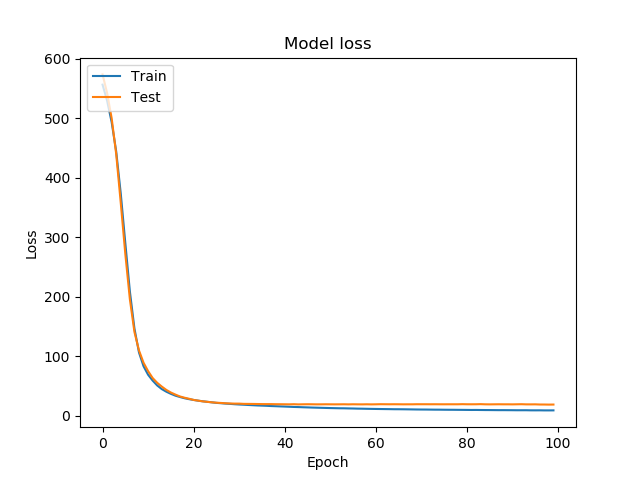

In [151]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


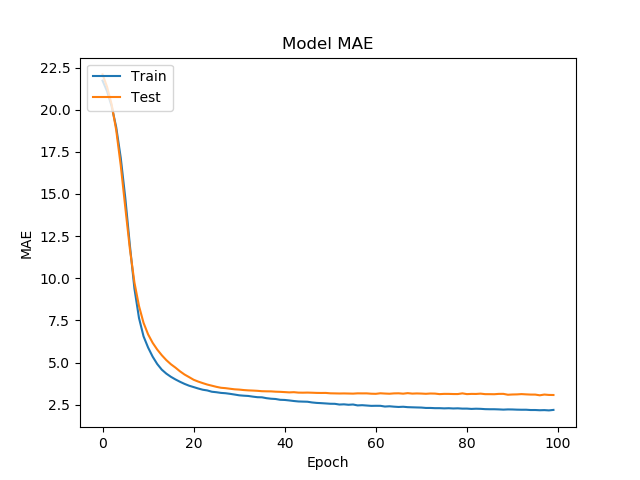

In [150]:
# Plot training & validation mae values
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [136]:
outputs = first_model.predict(test_df.values)

In [138]:
outputs.mean()

22.361946

In [139]:
y_train.mean()

22.395049504950492